# Détection d'Injections SQL par Machine Learning

## Mini Projet - Intelligence Artificielle

**Objectif** : Développer un système de détection automatique d'injections SQL en utilisant des techniques de Machine Learning.

**Dataset** : SQL Injection Dataset  
https://www.kaggle.com/datasets/sajid576/sql-injection-dataset
- 30,919 requêtes SQL (en raw strings)
- Label 0 : Requête normale 
- Label 1 : Injection SQL

## Étape 1 : Importer les bibliothèques nécessaires

In [4]:
# Bibliothèques de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Prétraitement de texte
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score

# Algorithmes de classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Métriques d'évaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Étape 2 : Charger et explorer le dataset

In [5]:
df = pd.read_csv('Modified_SQL_Dataset.csv')

# Affichage des premières lignes
print("=== Aperçu du dataset ===")
print(df.head(10))
print(f"\nDimensions : {df.shape}")
print(f"\nTypes de données :\n{df.dtypes}")
print(f"\nValeurs manquantes :\n{df.isnull().sum()}")

=== Aperçu du dataset ===
                                               Query  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1
5   select name from syscolumns where id   =     ...      1
6  select * from users where id  =  1 +$+ or 1  =...      1
7  1;  (  load_file  (  char  (  47,101,116,99,47...      1
8   select * from users where id  =  '1' or ||/1 ...      1
9   select * from users where id  =  '1' or \.<\ ...      1

Dimensions : (30919, 2)

Types de données :
Query    object
Label     int64
dtype: object

Valeurs manquantes :
Query    0
Label    0
dtype: int64


## Étape 3 : Analyse exploratoire des données (EDA)

=== Distribution des classes ===
Label
0    19537
1    11382
Name: count, dtype: int64

Pourcentage :
Label
0    63.187684
1    36.812316
Name: proportion, dtype: float64


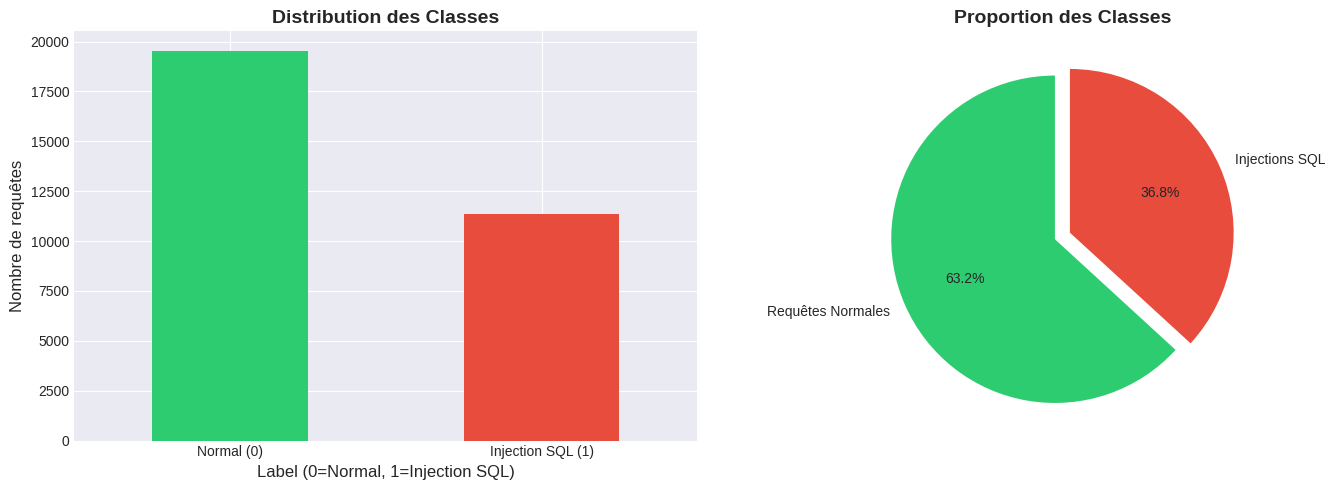

In [6]:
# Distribution des classes
print("=== Distribution des classes ===")
print(df['Label'].value_counts())
print(f"\nPourcentage :")
print(df['Label'].value_counts(normalize=True) * 100)

# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique en barres
df['Label'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label (0=Normal, 1=Injection SQL)', fontsize=12)
axes[0].set_ylabel('Nombre de requêtes', fontsize=12)
axes[0].set_xticklabels(['Normal (0)', 'Injection SQL (1)'], rotation=0)

# Graphique circulaire
labels_names = ['Requêtes Normales', 'Injections SQL']
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
df['Label'].value_counts().plot(kind='pie', ax=axes[1], labels=labels_names, 
                                 autopct='%1.1f%%', colors=colors, explode=explode, startangle=90)
axes[1].set_title('Proportion des Classes', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

=== Statistiques sur la longueur des requêtes ===
         count        mean        std  min   25%   50%    75%     max
Label                                                                
0      19537.0   39.911552  51.745808  1.0  11.0  35.0   56.0  5370.0
1      11382.0  118.611668  96.836996  1.0  51.0  85.0  150.0   456.0


<Figure size 1000x600 with 0 Axes>

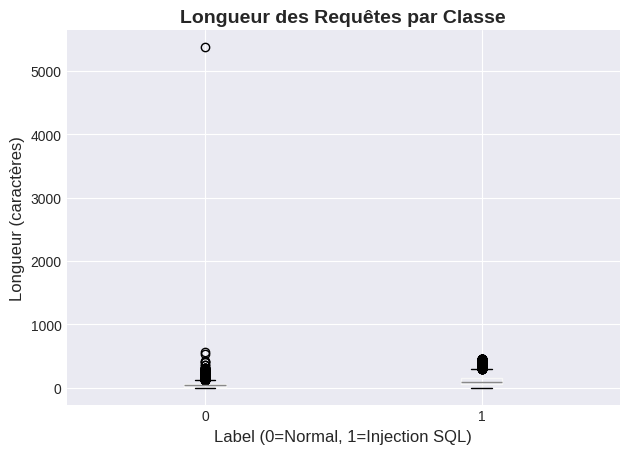

In [7]:
# Analyse de la longueur des requêtes
df['Query_Length'] = df['Query'].astype(str).apply(len)

print("=== Statistiques sur la longueur des requêtes ===")
print(df.groupby('Label')['Query_Length'].describe())

# Visualisation - Boxplot uniquement
plt.figure(figsize=(10, 6))
df.boxplot(column='Query_Length', by='Label')
plt.title('Longueur des Requêtes par Classe', fontsize=14, fontweight='bold')
plt.xlabel('Label (0=Normal, 1=Injection SQL)', fontsize=12)
plt.ylabel('Longueur (caractères)', fontsize=12)
plt.suptitle('')
plt.tight_layout()
plt.show()

In [8]:
# Exemples de requêtes
print("=== Exemples de Requêtes Normales ===")
for i, query in enumerate(df[df['Label'] == 0]['Query'].head(3), 1):
    print(f"{i}. {query}")

print("\n=== Exemples d'Injections SQL ===")
for i, query in enumerate(df[df['Label'] == 1]['Query'].head(3), 1):
    print(f"{i}. {query}")

=== Exemples de Requêtes Normales ===
1. 99745017c
2. ejerci78
3. 47209

=== Exemples d'Injections SQL ===
1. " or pg_sleep  (  __TIME__  )  --
2. create user name identified by pass123 temporary tablespace temp default tablespace users;
3.  AND 1  =  utl_inaddr.get_host_address   (    (   SELECT DISTINCT  (  table_name  )   FROM   (  SELECT DISTINCT  (  table_name  )  , ROWNUM AS LIMIT FROM sys.all_tables  )   WHERE LIMIT  =  5   )    )    AND 'i'  =  'i


## Étape 4 : Prétraitement des données

Nous utilisons la vectorisation **TF-IDF** (Term Frequency-Inverse Document Frequency) pour transformer les requêtes SQL en vecteurs numériques. Cette technique permet de capturer l'importance des mots dans chaque requête.

In [9]:
# Préparation des données
X = df['Query'].astype(str)
y = df['Label']

# Séparation en ensembles d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Entraînement : {len(X_train)} ({len(X_train)/len(X)*100:.1f}%) | Test : {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nDistribution train : {y_train.value_counts().to_dict()}")
print(f"Distribution test : {y_test.value_counts().to_dict()}")

Entraînement : 24735 (80.0%) | Test : 6184 (20.0%)

Distribution train : {0: 15629, 1: 9106}
Distribution test : {0: 3908, 1: 2276}


In [10]:
# Vectorisation TF-IDF
# max_features=5000 : on garde les 5000 mots les plus importants
# ngram_range=(1,3) : n-grammes de caractères de 1 à 3
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), analyzer='char')

# Entraînement du vectoriseur et transformation des données
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Forme des données d'entraînement : {X_train_tfidf.shape}")
print(f"Forme des données de test : {X_test_tfidf.shape}")

Forme des données d'entraînement : (24735, 5000)
Forme des données de test : (6184, 5000)


## Étape 5 : Implémentation et entraînement de plusieurs algorithmes

Nous allons tester plusieurs algorithmes de classification pour identifier celui qui offre les meilleures performances :
1. **Logistic Regression** : Algorithme linéaire simple et efficace
2. **Decision Tree** : Arbre de décision permettant une interprétation facile
3. **Random Forest** : Ensemble d'arbres de décision pour plus de robustesse
4. **Support Vector Machine (SVM)** : Algorithme puissant pour la classification
5. **Naive Bayes** : Algorithme probabiliste rapide
6. **Gradient Boosting** : Algorithme d'ensemble avec boosting

In [11]:
# Définition des modèles à tester
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Dictionnaire pour stocker les résultats
results = {}

print("=== Entraînement des modèles ===")
print("Cela peut prendre quelques minutes...\n")

for name, model in models.items():
    print(f"Entraînement de {name}...")
    
    # Entraînement du modèle
    model.fit(X_train_tfidf, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Stockage des résultats
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    print(f"  F1: {f1:.4f} | Accuracy: {accuracy:.4f} | Recall: {recall:.4f}")
    print()

print("✓ Tous les modèles ont été entraînés")

=== Entraînement des modèles ===
Cela peut prendre quelques minutes...

Entraînement de Logistic Regression...
  F1: 0.9936 | Accuracy: 0.9953 | Recall: 0.9881

Entraînement de Decision Tree...
  F1: 0.9903 | Accuracy: 0.9929 | Recall: 0.9833

Entraînement de Random Forest...
  F1: 0.9896 | Accuracy: 0.9924 | Recall: 0.9798

Entraînement de SVM...
  F1: 0.9958 | Accuracy: 0.9969 | Recall: 0.9925

Entraînement de Naive Bayes...
  F1: 0.9136 | Accuracy: 0.9316 | Recall: 0.9829

Entraînement de Gradient Boosting...
  F1: 0.9929 | Accuracy: 0.9948 | Recall: 0.9877

✓ Tous les modèles ont été entraînés


## Étape 6 : Comparaison des performances des modèles

In [12]:
# Création d'un DataFrame pour comparer les performances
comparison_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] if results[m]['roc_auc'] else 0 for m in results]
})

# Tri par F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("=== Comparaison des Performances ===")
print(comparison_df.to_string(index=False))

# Identification du meilleur modèle
best_model_name = comparison_df.iloc[0]['Modèle']
print(f"\n🏆 Meilleur modèle : {best_model_name}")
print(f"   F1-Score : {comparison_df.iloc[0]['F1-Score']:.4f}")

=== Comparaison des Performances ===
             Modèle  Accuracy  Precision   Recall  F1-Score  ROC-AUC
                SVM  0.996928   0.999115 0.992531  0.995812 0.998191
Logistic Regression  0.995310   0.999112 0.988137  0.993594 0.997566
  Gradient Boosting  0.994825   0.998224 0.987698  0.992933 0.998021
      Decision Tree  0.992885   0.997326 0.983304  0.990265 0.990481
      Random Forest  0.992400   0.999552 0.979789  0.989572 0.997903
        Naive Bayes  0.931598   0.853491 0.982865  0.913621 0.995981

🏆 Meilleur modèle : SVM
   F1-Score : 0.9958


## Étape 7 : Analyse détaillée du meilleur modèle

In [13]:
# Récupération du meilleur modèle
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred']

# Rapport de classification détaillé
print(f"=== Rapport de Classification - {best_model_name} ===")
print(classification_report(y_test, y_pred_best, target_names=['Normal', 'Injection SQL']))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_best)
print(f"\nMatrice de Confusion :")
print(cm)

=== Rapport de Classification - SVM ===
               precision    recall  f1-score   support

       Normal       1.00      1.00      1.00      3908
Injection SQL       1.00      0.99      1.00      2276

     accuracy                           1.00      6184
    macro avg       1.00      1.00      1.00      6184
 weighted avg       1.00      1.00      1.00      6184


Matrice de Confusion :
[[3906    2]
 [  17 2259]]


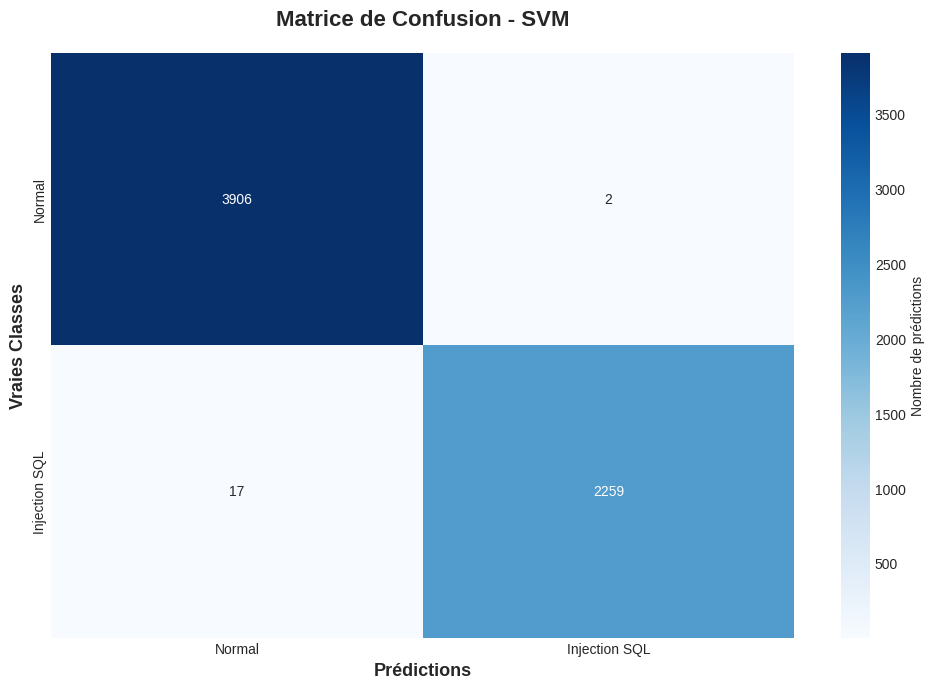


=== Analyse ===
Vrais Négatifs : 3906 | Faux Positifs : 2
Faux Négatifs : 17 | Vrais Positifs : 2259

Taux de détection (Recall) : 99.25%
Taux de faux positifs : 0.05%


In [14]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Injection SQL'],
            yticklabels=['Normal', 'Injection SQL'],
            cbar_kws={'label': 'Nombre de prédictions'})
plt.title(f'Matrice de Confusion - {best_model_name}', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prédictions', fontsize=13, fontweight='bold')
plt.ylabel('Vraies Classes', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Calcul des taux
tn, fp, fn, tp = cm.ravel()
print(f"\n=== Analyse ===")
print(f"Vrais Négatifs : {tn} | Faux Positifs : {fp}")
print(f"Faux Négatifs : {fn} | Vrais Positifs : {tp}")
print(f"\nTaux de détection (Recall) : {tp/(tp+fn):.2%}")
print(f"Taux de faux positifs : {fp/(fp+tn):.2%}")

## Étape 8 : Courbes ROC et AUC

La courbe ROC (Receiver Operating Characteristic) permet de visualiser les performances du modèle en fonction du seuil de décision. L'AUC (Area Under Curve) mesure la qualité globale du modèle.

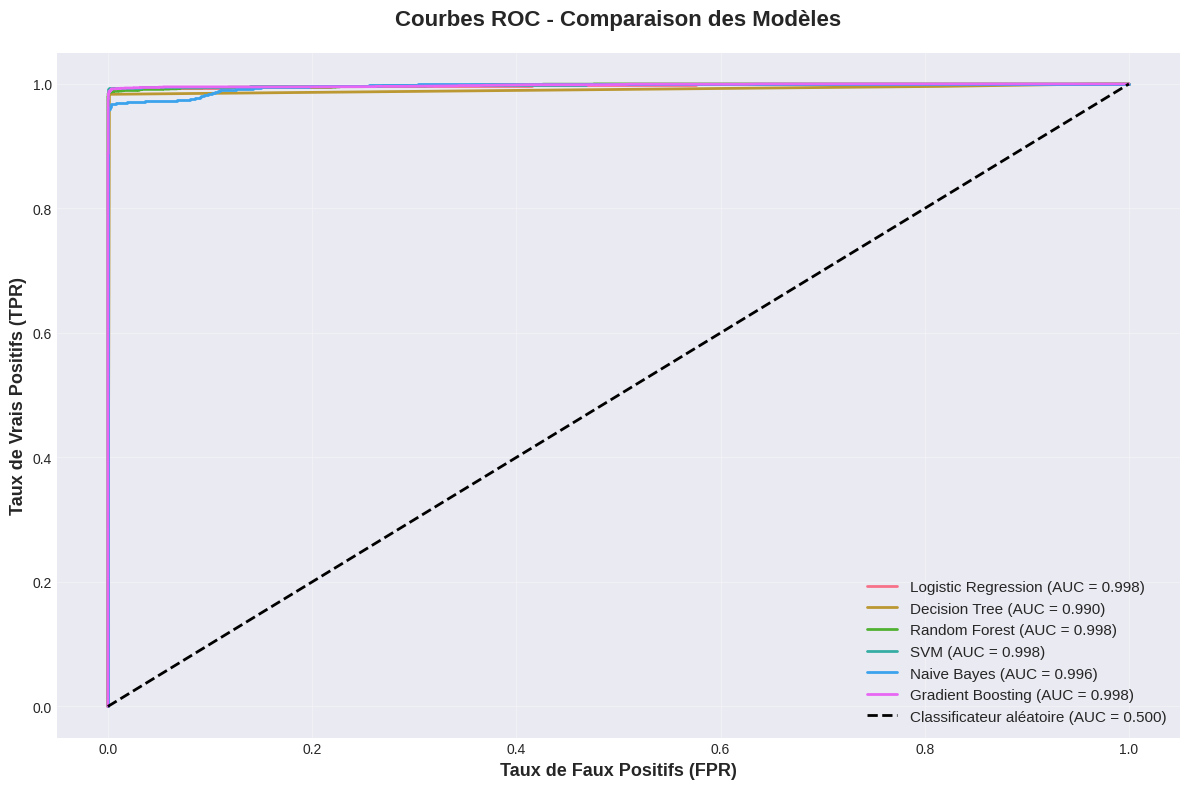

In [15]:
# Tracer les courbes ROC pour tous les modèles
plt.figure(figsize=(12, 8))

for name in results:
    if results[name]['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc_score:.3f})')

# Ligne diagonale (classificateur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Classificateur aléatoire (AUC = 0.500)')

plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=13, fontweight='bold')
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=13, fontweight='bold')
plt.title('Courbes ROC - Comparaison des Modèles', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Étape 9 : Validation croisée

La validation croisée permet d'évaluer la robustesse du modèle sur différentes partitions des données.

=== Validation Croisée (5-Fold) - SVM ===

Scores F1 : ['0.9626', '0.9985', '0.9316', '1.0000', '0.9929']
Score F1 moyen : 0.9771 (± 0.0265)


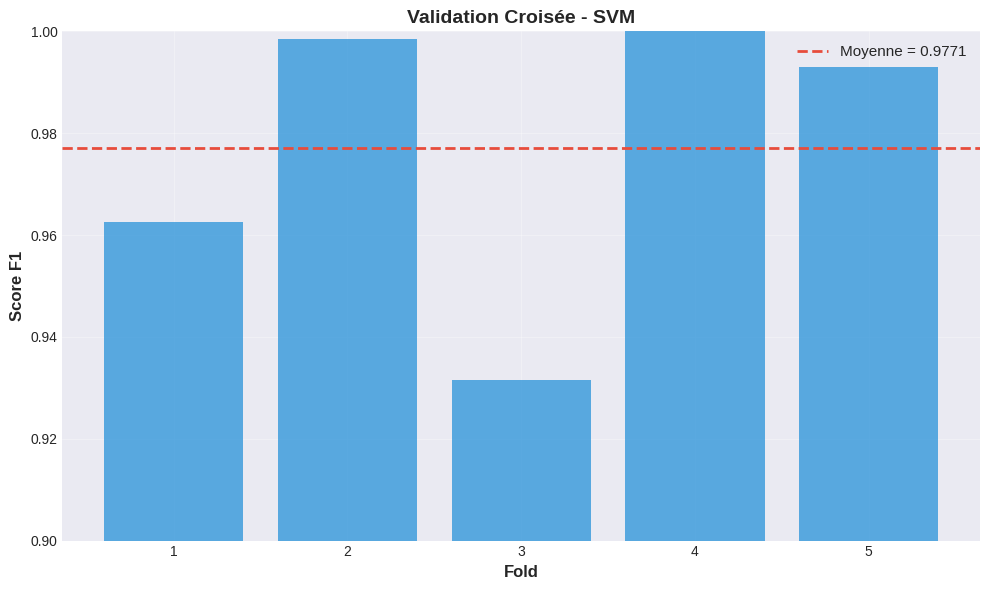

In [16]:
# Validation croisée sur le meilleur modèle
print(f"=== Validation Croisée (5-Fold) - {best_model_name} ===")

# Vectorisation de toutes les données
X_all_tfidf = vectorizer.transform(X)

# Validation croisée
cv_scores = cross_val_score(best_model, X_all_tfidf, y, cv=5, scoring='f1')

print(f"\nScores F1 : {[f'{s:.4f}' for s in cv_scores]}")
print(f"Score F1 moyen : {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, color='#3498db', alpha=0.8)
plt.axhline(y=cv_scores.mean(), color='#e74c3c', linestyle='--', linewidth=2, 
            label=f'Moyenne = {cv_scores.mean():.4f}')
plt.xlabel('Fold', fontsize=12, fontweight='bold')
plt.ylabel('Score F1', fontsize=12, fontweight='bold')
plt.title(f'Validation Croisée - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.ylim(0.9, 1.0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Étape 10 : Test sur de nouvelles requêtes

Testons notre modèle sur quelques exemples de requêtes SQL pour vérifier son comportement.

In [17]:
# Fonction de prédiction
def predict_sql_injection(query, model, vectorizer):
    """
    Prédit si une requête SQL est une injection ou non.
    """
    query_vectorized = vectorizer.transform([query])
    prediction = model.predict(query_vectorized)[0]
    proba = model.predict_proba(query_vectorized)[0] if hasattr(model, 'predict_proba') else None
    
    result = "🔴 INJECTION SQL DÉTECTÉE" if prediction == 1 else "✅ REQUÊTE NORMALE"
    
    if proba is not None:
        confidence = proba[prediction] * 100
        return result, confidence
    return result, None

# Exemples de requêtes à tester
test_queries = [
    "SELECT * FROM users WHERE id = 123",
    "SELECT * FROM products WHERE name = 'laptop'",
    "1' OR '1'='1",
    "admin' --",
    "SELECT * FROM users WHERE id = 1 UNION SELECT null, username, password FROM admin",
    "' OR 1=1 --",
    "DELETE FROM users",
    "SELECT name, email FROM customers WHERE country = 'France'",
]

print("=== Test sur de Nouvelles Requêtes ===\n")

for i, query in enumerate(test_queries, 1):
    result, confidence = predict_sql_injection(query, best_model, vectorizer)
    print(f"Requête {i}: {query}")
    print(f"Résultat: {result}", end="")
    if confidence:
        print(f" (Confiance: {confidence:.2f}%)")
    else:
        print()
    print("-" * 80)
    print()

=== Test sur de Nouvelles Requêtes ===

Requête 1: SELECT * FROM users WHERE id = 123
Résultat: ✅ REQUÊTE NORMALE (Confiance: 95.69%)
--------------------------------------------------------------------------------

Requête 2: SELECT * FROM products WHERE name = 'laptop'
Résultat: ✅ REQUÊTE NORMALE (Confiance: 99.99%)
--------------------------------------------------------------------------------

Requête 3: 1' OR '1'='1
Résultat: 🔴 INJECTION SQL DÉTECTÉE (Confiance: 100.00%)
--------------------------------------------------------------------------------

Requête 4: admin' --
Résultat: 🔴 INJECTION SQL DÉTECTÉE (Confiance: 100.00%)
--------------------------------------------------------------------------------

Requête 5: SELECT * FROM users WHERE id = 1 UNION SELECT null, username, password FROM admin
Résultat: ✅ REQUÊTE NORMALE (Confiance: 72.70%)
--------------------------------------------------------------------------------

Requête 6: ' OR 1=1 --
Résultat: 🔴 INJECTION SQL DÉTEC

## Étape 11 : Analyse des features importantes

Pour certains modèles (comme Random Forest), nous pouvons analyser quelles caractéristiques (features) sont les plus importantes pour la détection.

In [18]:
# Analyse des features importantes (si le modèle le supporte)
if hasattr(best_model, 'feature_importances_'):
    print(f"=== Top 10 Features Importantes - {best_model_name} ===")
    
    # Récupération des features et de leur importance
    feature_names = vectorizer.get_feature_names_out()
    importances = best_model.feature_importances_
    
    # Tri par importance décroissante - Top 10
    indices = np.argsort(importances)[-10:]
    
    # Visualisation
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(indices)), importances[indices], color='#e74c3c', alpha=0.8)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top 10 Features Importantes - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 des caractéristiques les plus importantes :")
    for i, idx in enumerate(reversed(indices), 1):
        print(f"{i:2d}. {feature_names[idx]:30s} - Importance: {importances[idx]:.6f}")
else:
    print(f"Le modèle {best_model_name} ne supporte pas l'analyse des features importantes.")

Le modèle SVM ne supporte pas l'analyse des features importantes.
